# On-Device AI Co., Ltd.

Web   : https://on-device-ai.com/  
Email : yilintung@on-device-ai.com

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def show_confusion_matrix(confusion_matrix):
    print('\n' + str(confusion_matrix))
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.values.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    print('acc  = ' + str(round(ACC[0]*100.0,2)) + '% , ' + \
          str(round(ACC[1]*100.0,2)) + '% , ' + \
          str(round(ACC[2]*100.0,2)) + '% , ' + \
          str(round(ACC[3]*100.0,2)) + '% , ' + \
          str(round(ACC[4]*100.0,2)) + '% ')
    print('ppv  = ' + str(round(PPV[0]*100.0,2)) + '% , ' + \
          str(round(PPV[1]*100.0,2)) + '% , ' + \
          str(round(PPV[2]*100.0,2)) + '% , ' + \
          str(round(PPV[3]*100.0,2)) + '% , ' + \
          str(round(PPV[4]*100.0,2)) + '% ')
    print('sen  = ' + str(round(TPR[0]*100.0,2)) + '% , ' + \
          str(round(TPR[1]*100.0,2)) + '% , ' + \
          str(round(TPR[2]*100.0,2)) + '% , ' + \
          str(round(TPR[3]*100.0,2)) + '% , ' + \
          str(round(TPR[4]*100.0,2)) + '% ')
    print('spec = ' + str(round(TNR[0]*100.0,2)) + '% , ' + \
          str(round(TNR[1]*100.0,2)) + '% , ' + \
          str(round(TNR[2]*100.0,2)) + '% , ' + \
          str(round(TNR[3]*100.0,2)) + '% , ' + \
          str(round(TNR[4]*100.0,2)) + '% ')

In [3]:
# MIT-BIH Arrhythmia Database
# https://physionet.org/content/mitdb/1.0.0/
mitdbs = [100,101,102,103,104,105,106,107,108,109,111,112,113,114,115,116,117,118,119,121,122,123,124,200,201,202,203,205,207,208,209,210,212,213,214,215,217,219,220,221,222,223,228,230,231,232,233,234]

In [4]:
X_list = list() 
y_list = list()
for db in mitdbs:
    if os.path.isfile('./beats/'+ str(db) + '.npy') : 
        db_dict = np.load('./beats/'+ str(db) + '.npy').item()
        beats   = db_dict['beats']
    
        for beat in beats :
            # X is ECG signal
            X_list.append(beat[1])
            # y is categorie
            y_list.append(beat[0])
    else :
        print('./beats/'+ str(db) + '.npy' + ' file is not exist')
        
X = np.array(X_list)
y = np.array(y_list)

./beats/102.npy file is not exist
./beats/104.npy file is not exist


In [5]:
print('Type N number of beats = ' + str(len(np.where(y==0)[0])))
print('Type S number of beats = ' + str(len(np.where(y==1)[0])))
print('Type V number of beats = ' + str(len(np.where(y==2)[0])))
print('Type F number of beats = ' + str(len(np.where(y==3)[0])))
print('Type Q number of beats = ' + str(len(np.where(y==4)[0])))
print('Total  number of beats = ' + str(len(y)))

Type N number of beats = 90078
Type S number of beats = 2704
Type V number of beats = 6271
Type F number of beats = 786
Type Q number of beats = 3582
Total  number of beats = 103421


In [6]:
weight0 = 1.0 - (len(np.where(y==0)[0]) / len(y))
weight1 = 1.0 - (len(np.where(y==1)[0]) / len(y))
weight2 = 1.0 - (len(np.where(y==2)[0]) / len(y))
weight3 = 1.0 - (len(np.where(y==3)[0]) / len(y))
weight4 = 1.0 - (len(np.where(y==4)[0]) / len(y))
class_weight = {0: weight0 , 1: weight1 , 2: weight2 ,3 : weight3 , 4 : weight4}
print(class_weight)

{0: 0.12901635064445327, 1: 0.9738544396205799, 2: 0.9393643457324915, 3: 0.9923999961323136, 4: 0.9653648678701617}


In [7]:
# Create train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

num_classes = 5

y_Train=keras.utils.to_categorical(y_train,num_classes)
y_Train=y_Train.reshape(len(y_Train),num_classes)

y_Test=keras.utils.to_categorical(y_test,num_classes)
y_Test=y_Test.reshape(len(y_Test),num_classes)

In [8]:
# 1D Convolutional Neural Network
# Ref. : A deep convolutional neural network model to classify heartbeats ( https://www.sciencedirect.com/science/article/pii/S0010482517302810?via%3Dihub )
inputs  = layers.Input(shape=(260,))
reshape = layers.Reshape((260,1))(inputs)
conv1   = layers.Conv1D(5,  3, activation='linear')(reshape)
conv1   = layers.ReLU()(conv1)
conv1   = layers.MaxPooling1D(2,2)(conv1)
conv2   = layers.Conv1D(10, 4, activation='linear')(conv1)
conv2   = layers.ReLU()(conv2)
conv2   = layers.MaxPooling1D(2,2)(conv2)
conv3   = layers.Conv1D(20, 4, activation='linear')(conv2)
conv3   = layers.ReLU()(conv3)
conv3   = layers.MaxPooling1D(2,2)(conv3)
flat    = layers.Flatten()(conv3)
dense1  = layers.Dense(30, activation='linear')(flat)
dense1  = layers.ReLU()(dense1)
dense2  = layers.Dense(20, activation='linear')(dense1)
dense2  = layers.ReLU()(dense2)
dense3  = layers.Dense(5, activation='softmax')(dense2)
model   = keras.Model(inputs=inputs, outputs=dense3)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 260)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 260, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 258, 5)            20        
_________________________________________________________________
re_lu (ReLU)                 (None, 258, 5)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 129, 5)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 126, 10)           210       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 126, 10)           0     

In [9]:
# Configures the model for training
model.compile(keras.optimizers.Adam(),loss=keras.losses.CategoricalCrossentropy(),metrics=[keras.metrics.CategoricalAccuracy()])

In [10]:
# Stop training when a monitored quantity has stopped improving
earlyStopping=keras.callbacks.EarlyStopping(monitor= 'val_loss',patience=3)

In [11]:
# Trains the model for a fixed number of epochs (iterations on a dataset)
train_history = model.fit(X_train, y_Train, batch_size=32, epochs=20, validation_split=0.3, callbacks=[earlyStopping],class_weight = class_weight)

Train on 65154 samples, validate on 27924 samples
Epoch 1/20
65154/65154 [==============================] - 7s 114us/sample - loss: 0.0746 - categorical_accuracy: 0.9427 - val_loss: 0.0453 - val_categorical_accuracy: 0.9714
Epoch 2/20
65154/65154 [==============================] - 6s 87us/sample - loss: 0.0420 - categorical_accuracy: 0.9666 - val_loss: 0.0429 - val_categorical_accuracy: 0.9746
Epoch 3/20
65154/65154 [==============================] - 6s 87us/sample - loss: 0.0335 - categorical_accuracy: 0.9714 - val_loss: 0.0345 - val_categorical_accuracy: 0.9775
Epoch 4/20
65154/65154 [==============================] - 6s 88us/sample - loss: 0.0292 - categorical_accuracy: 0.9744 - val_loss: 0.0332 - val_categorical_accuracy: 0.9799
Epoch 5/20
65154/65154 [==============================] - 6s 88us/sample - loss: 0.0260 - categorical_accuracy: 0.9771 - val_loss: 0.0280 - val_categorical_accuracy: 0.9762
Epoch 6/20
65154/65154 [==============================] - 6s 87us/sample - loss: 0.0

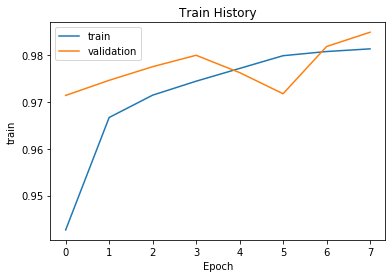

In [12]:
show_train_history(train_history, 'categorical_accuracy', 'val_categorical_accuracy')

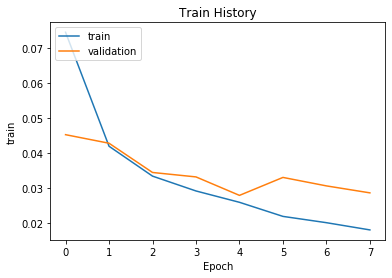

In [13]:
show_train_history(train_history, 'loss', 'val_loss')

In [14]:
# Returns the loss value & metrics values for the model in test mode
score = model.evaluate(X_test, y_Test, batch_size=32 , verbose=0)
print('Model evaluate score = ' + str(score))

Model evaluate score = [0.04983681906455895, 0.9858842]


In [15]:
# Generates output predictions for the input samples
prediction = model.predict(X_test,batch_size=32)

In [16]:
prediction = prediction.argmax(axis=-1)
confusion_matrix = pd.crosstab(y_test, prediction, rownames=['label'], colnames=['predict'])
show_confusion_matrix(confusion_matrix)


predict     0    1    2   3    4
label                           
0        8888   37   19  15    0
1          36  224    3   1    0
2          15    1  630   4    0
3           7    0    8  61    0
4           0    0    0   0  394
acc  = 98.75% , 99.25% , 99.52% , 99.66% , 100.0% 
ppv  = 99.35% , 85.5% , 95.45% , 75.31% , 100.0% 
sen  = 99.21% , 84.85% , 96.92% , 80.26% , 100.0% 
spec = 95.81% , 99.62% , 99.69% , 99.81% , 100.0% 


In [17]:
# Save model
# Defaults to 'tf' (Tensorflow SavedModel) in TF 2.X
model.save('classify_heartbeats_cnn')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: classify_heartbeats_cnn/assets


# Convert to TensorFlow Lite

In [18]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [19]:
# Save the model to disk
open("classify_heartbeats_cnn.tflite", "wb").write(tflite_model)

84280

In [20]:
# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
train_sub_dataset = X_train[0:100]
def representative_data_gen():
  for input_value in train_sub_dataset:
    yield [input_value.reshape(1,260)]
converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()

In [21]:
# Save the model to disk
open("classify_heartbeats_cnn_quantized.tflite", "wb").write(tflite_model)

27368

# Test the converted models

In [22]:
# Instantiate an interpreter for each model
heartbeat_model = tf.lite.Interpreter('classify_heartbeats_cnn.tflite')
heartbeat_model_quantized = tf.lite.Interpreter('classify_heartbeats_cnn_quantized.tflite')

In [23]:
# Allocate memory for each model
heartbeat_model.allocate_tensors()
heartbeat_model_quantized.allocate_tensors()

In [24]:
# Get input and output tensors.
heartbeat_model_input  = heartbeat_model.get_input_details()
heartbeat_model_output = heartbeat_model.get_output_details()

heartbeat_model_quantized_input  = heartbeat_model_quantized.get_input_details()
heartbeat_model_quantized_output = heartbeat_model_quantized.get_output_details()

In [25]:
# Create arrays to store the results
heartbeat_model_predictions = np.empty(len(X_test),dtype=np.int64)
heartbeat_model_quantized_predictions = np.empty(len(X_test),dtype=np.int64)

In [26]:
# Run each model's interpreter for each value and store the results in arrays
for i in range(len(X_test)):
  heartbeat_model.set_tensor(heartbeat_model_input[0]['index'], X_test[i].reshape(1,260))
  heartbeat_model.invoke()
  heartbeat_model_predictions[i] = heartbeat_model.get_tensor(heartbeat_model_output[0]['index']).argmax(-1)[0]

  heartbeat_model_quantized.set_tensor(heartbeat_model_quantized_input[0]['index'], X_test[i].reshape(1,260))
  heartbeat_model_quantized.invoke()
  heartbeat_model_quantized_predictions[i] = heartbeat_model_quantized.get_tensor(heartbeat_model_quantized_output[0]['index']).argmax(-1)[0] 

In [27]:
print("heartbeat_model accuracy score is " + str(accuracy_score(y_test,heartbeat_model_predictions)))
print("heartbeat_model_quantized accuracy score is " + str(accuracy_score(y_test,heartbeat_model_quantized_predictions)))

heartbeat_model accuracy score is 0.9858841728705404
heartbeat_model_quantized accuracy score is 0.9864642753553128


# Write to C file

In [28]:
!xxd -i classify_heartbeats_cnn.tflite > classify_heartbeats_cnn.cc

In [29]:
!xxd -i classify_heartbeats_cnn_quantized.tflite > classify_heartbeats_cnn_quantized.cc

# Generate the test signals for MCU

In [30]:
start_index  = 0
end_index    = len(y_Test) - 1
for type in range(0,5) :
    signal_found = False
    while(signal_found is False) :
        index = np.random.randint(start_index,end_index)
        while(index < end_index) :
            if y_test[index] == type :
                if type == 0 :
                    signal_typeN = X_test[index]
                elif type == 1:
                    signal_typeS = X_test[index]
                elif type == 2:
                    signal_typeV = X_test[index]
                elif type == 3:
                    signal_typeF = X_test[index]
                elif type == 4:
                    signal_typeQ = X_test[index]
                signal_found = True
                break    
            index += 1

In [31]:
np.set_printoptions(formatter={'float_kind': '{: .8f}'.format})

text_file = open("heartbeats_signal.h", "w")

label is 0 , prediction is 0


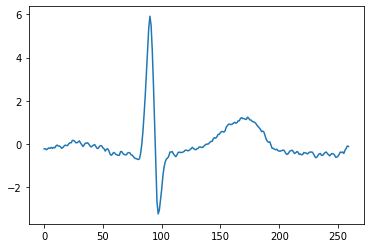

In [32]:
heartbeat_model_quantized.set_tensor(heartbeat_model_quantized_input[0]['index'],  signal_typeN.reshape(1,260))
heartbeat_model_quantized.invoke()
prediction = heartbeat_model_quantized.get_tensor(heartbeat_model_quantized_output[0]['index']).argmax(-1)[0] 

print('label is 0 , prediction is ' + str(prediction))
plt.plot(signal_typeN)
plt.show()

ndarray_str = np.array2string(signal_typeN,separator=',')
ndarray_str = ndarray_str.replace('[','{')
ndarray_str = ndarray_str.replace(']','}')
ndarray_str = 'const float signalN[260] = ' + ndarray_str + ';\n\n'
text_file.write(ndarray_str);

label is 1 , prediction is 1


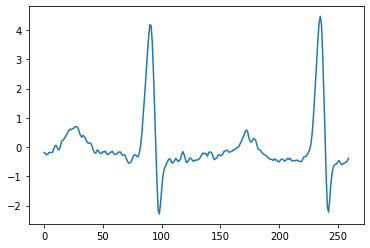

In [33]:
heartbeat_model_quantized.set_tensor(heartbeat_model_quantized_input[0]['index'], signal_typeS.reshape(1,260))
heartbeat_model_quantized.invoke()
prediction = heartbeat_model_quantized.get_tensor(heartbeat_model_quantized_output[0]['index']).argmax(-1)[0] 

print('label is 1 , prediction is ' + str(prediction))
plt.plot(signal_typeS)
plt.show()

ndarray_str = np.array2string(signal_typeS,separator=',')
ndarray_str = ndarray_str.replace('[','{')
ndarray_str = ndarray_str.replace(']','}')
ndarray_str = 'const float signalS[260] = ' + ndarray_str + ';\n\n'
text_file.write(ndarray_str);

label is 2 , prediction is 2


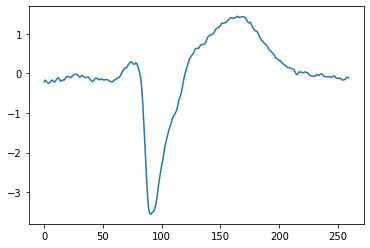

In [34]:
heartbeat_model_quantized.set_tensor(heartbeat_model_quantized_input[0]['index'], signal_typeV.reshape(1,260))
heartbeat_model_quantized.invoke()
prediction = heartbeat_model_quantized.get_tensor(heartbeat_model_quantized_output[0]['index']).argmax(-1)[0] 

print('label is 2 , prediction is ' + str(prediction))
plt.plot(signal_typeV)
plt.show()

ndarray_str = np.array2string(signal_typeV,separator=',')
ndarray_str = ndarray_str.replace('[','{')
ndarray_str = ndarray_str.replace(']','}')
ndarray_str = 'const float signalV[260] = ' + ndarray_str + ';\n\n'
text_file.write(ndarray_str);

label is 3 , prediction is 3


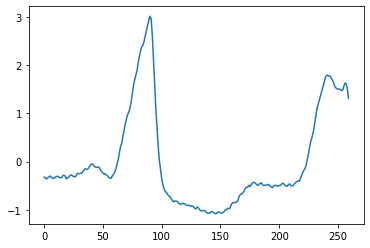

In [35]:
heartbeat_model_quantized.set_tensor(heartbeat_model_quantized_input[0]['index'], signal_typeF.reshape(1,260))
heartbeat_model_quantized.invoke()
prediction = heartbeat_model_quantized.get_tensor(heartbeat_model_quantized_output[0]['index']).argmax(-1)[0] 

print('label is 3 , prediction is ' + str(prediction))
plt.plot(signal_typeF)
plt.show()

ndarray_str = np.array2string(signal_typeF,separator=',')
ndarray_str = ndarray_str.replace('[','{')
ndarray_str = ndarray_str.replace(']','}')
ndarray_str = 'const float signalF[260] = ' + ndarray_str + ';\n\n'
text_file.write(ndarray_str);

label is 4 , prediction is 4


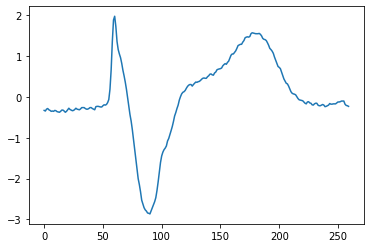

In [36]:
heartbeat_model_quantized.set_tensor(heartbeat_model_quantized_input[0]['index'], signal_typeQ.reshape(1,260))
heartbeat_model_quantized.invoke()
prediction = heartbeat_model_quantized.get_tensor(heartbeat_model_quantized_output[0]['index']).argmax(-1)[0] 

print('label is 4 , prediction is ' + str(prediction))
plt.plot(signal_typeQ)
plt.show()

ndarray_str = np.array2string(signal_typeQ,separator=',')
ndarray_str = ndarray_str.replace('[','{')
ndarray_str = ndarray_str.replace(']','}')
ndarray_str = 'const float signalQ[260] = ' + ndarray_str + ';\n\n'
text_file.write(ndarray_str);

In [37]:
text_file.close()

np.set_printoptions();